Please fill in your name and that of your teammate.

You: Bhargav Solanki

Teammate: Carmen Sangro Prieto

# Introduction

Welcome to the sixth lab. Last week we attacked classification problems expanding the concept of LDA, interpreting the data as generated from probability distributions, into Naïve Bayes. Today we follow the same plan from the perspective of the _margin_, starting with the Perceptron expanding it into the Support Vector Machine.

You will notice we will not implement the learning algorithm this time, because SVMs are solved through quadratic programming and that is not fun. But please feel free to check out quadratic programming yourself if you are interested.

Today we focus on the ample new glossary, then implementing the SVM objective function, and using off-the-shelf optimizers for training. Enjoy!

## Load your libraries

**FROM NOW ON:** take a habit of loading your default libraries, plotting style and external tools at the top of the file (as I do here). I will not mention it further in the next labs, it will be up to you to load what you need.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set(rc={'figure.figsize':(8,6)}, style="whitegrid")

### How to pass the lab?

Below you find the exercise questions. Each question awarding points is numbered and states the number of points like this: **[0pt]**. To answer a question, fill the cell below with your answer (markdown for text, code for implementation). Incorrect or incomplete answers are in principle worth 0 points: to assign partial reward is only up to teacher discretion. Over-complete answers do not award extra points (though they are appreciated and will be kept under consideration). Save your work frequently! (`ctrl+s`)

**You need at least 18 points (out of 27 available) to pass** (66%).

# 1. Fundamentals

#### 1.1 **[1pt]** Write the equation for the margin (use latex).

$E_i = y_i . (\langle w, x_i \rangle + b)$

#### 1.2 **[2pt]** Write the equation for the maximum margin separation (use latex), then explain it in English below.

$$ \text{arg}\!\max_{w, b}\{\gamma\}  \ s.t.  \;\;\forall i \in \{1,...,n\}:$$

$$y_i \times (\langle w, x \rangle + b) \geq \gamma$$

under the condition that the norm of vector w is equal to 1: 
$$\|w\| = 1$$
We want to maximise γ. And γ = 1/||w||. We get rid of γ and keep only w. We minimise the norm of w squared.  it basically means, we want to find a margin that is closest to the hyperplane, but still want to maximize the distance from the hyper plane.

#### 1.3 **[1pt]** When is an *example* (in a dataset) considered a Support Vector? Write its definition using latex, then explain it in English.

support vectors (SV)  for point $(x_i,y_i)$ with the minimal margin and such that $y_i.f(x_i) = 1 \ $
It basically means that once we draw the hyper plane, the points(vectors) closest to the hyper plane help decide the margin and are called the support vectors.

#### 1.4 **[1pt]** Explain in English why SVMs ignore examples that are not Support Vectors.

SVMs are pbasically the vectors closest to the hyper plane which help decide the hyper plane. Once the hyper plane is made and the margins are decided, any points further away on the correct side are already correctly classified. So we ignore them. 

#### 1.5 **[2pt]** Define each of the following concepts (in English): Quadratic Program, Slack Variable, Multiobjective Optimization, with your own words.

Tip: if you want to write something with your own words, you can read a description of it, then put the description away and immediately try to explain it again as if to someone that has no background on it. This of course only works if you have understood the concepts, else you'll find yourself just changing words but reusing the sentences: please avoid that (as the goal is to force you to understand the concepts).  
Incidentally, this is also why studying in pairs/groups works (typically) better: explaining concepts to each other forces you to confront how much did you really understand of it.

#### Quadratic Program:
When we want to mathematically optimise ( maximise/minimse) a function, which happens to be quadratic, its called quadratic program

#### Slack variable:
When we optmise a function, subject to inequality constraints, in order to get rid of inequality onstraints we introduce variables, that change >= or <= to =. Its much easier to solve eqalities. $ s^2$. In order to get rid of >=  we introduce  $ - s^2$ and change to "=".  In SVM we have xi as the slack variable which allows some violations.
For SVM we have have $ξ_i$ as a slack variable.
#### Multiobjective Optimization:
When we have two or more optimizations that we need to achieve at the same time its called multiobjective optimization. For eg: maximise comfort with minimise cost of a car. In SVM, we try to maximise margin, and minimize the violations . two objectives hence multiobjective

#### 1.6 **[3pt]** Write the full formula for the Soft Margin SVM (geometric approach; use latex), then explain in English the role of the hyperparameter C (particularly: what do high or low values mean for the SVM).

 \begin{equation}
\underset{w,x,b}{argmin} \left\{ \frac{1}{2} ||w||^2 + C . \sum_{i=1}^{n} \xi_i\right\} \ s.t. ∀i ∈ {1, . . . , n} \\
y_i. (\langle w, x_i +b \rangle) \geq 1 - \xi_i \\ and \\  \xi  \geq 0
\end{equation} 
Hyper parameter C is is the punisher in my opinion. Xi is the violater. C decides the intensity of the punishment. Higher value of C means, more punishment. More punishment, means less room from violations thus smaller distance between margin and hyper plane, and higher lower C means, higher tolerence for violations and thus thicker margin. 
 
A large value of  means we have a high penalty on errors and hence our model is not allowed to make too many mistakes in classification. A small value of  allows the errors to grow.



#### 1.7 **[2pt]** Write the objective function for the Soft Margin SVM (use latex) using the Regularized Empirical Risk Minimization approach and a Squared Hinge Loss for `L(m)`.

This is no copy-paste, think! Do you remember the difference between the Loss on a _point_, the Loss on a _boundary_, and the _Risk_? You need these concepts super clear for the exam!

 \begin{equation}
\underset{w,x,b}{argmin} \left\{ \frac{1}{2} ||w||^2 + C . \sum_{i=1}^{n} L(y_i· (\langle w, x_i\rangle + b ))
\right\} \ s.t. ∀i ∈ {1, . . . , n} \\
where \\
L(m) = max\{0, 1 − y · f (x )\}^2  <- Squared Hinge Loss \\  
and \\
m = y_i· (\langle w, x_i\rangle + b )
\end{equation} 

Here we replace Xi with Loss function. And this given case, our loss function is Squared Hinge Loss 
 

# 2. Soft Margin SVM

- Following what we learned in the last exercise: **all** of the questions below need to be solved using Pandas and **no Python loops** (`for`, `while`, etc).
- Let's classify the Iris dataset with a hand-made SVM. Working with margins though means we need to set up once again for **binary classification**. Last time we used the categorical feature type, but this time we need the numerical values for the two classes to be of integer type in $\{-1, 1\}$, because we work with margin calculations. How would you do it? Here's one way to get it done:

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species           int64
dtype: object


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,-1
1,4.9,3.0,1.4,0.2,-1
2,4.7,3.2,1.3,0.2,-1
3,4.6,3.1,1.5,0.2,-1
4,5.0,3.6,1.4,0.2,-1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1


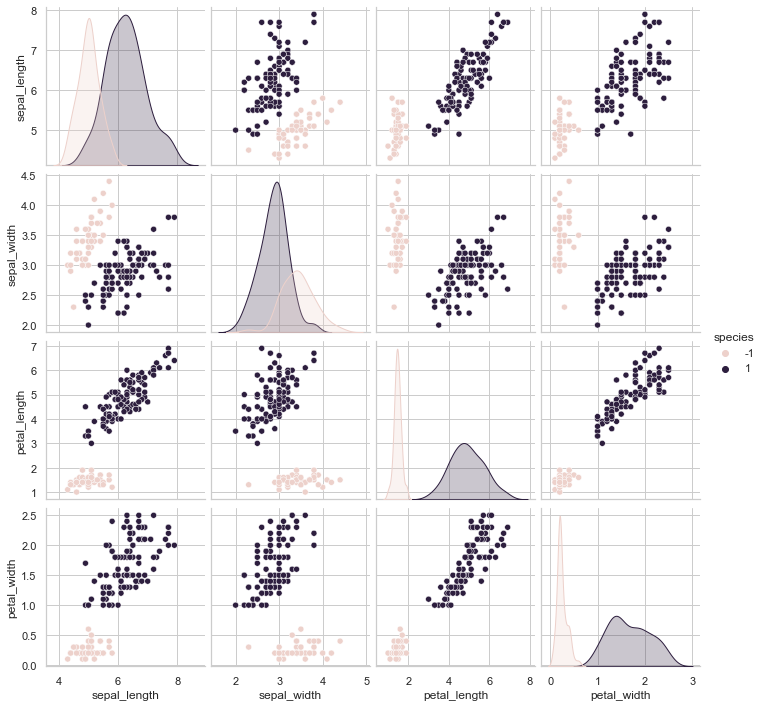

In [5]:
df = sns.load_dataset('iris')
# sns.pairplot(df, hue='species')

df.loc[df['species'] == 'setosa', 'species'] = -1
df.loc[df['species'] != -1, 'species'] = 1
df['species'] = pd.to_numeric(df['species'])
print(df.dtypes)
sns.pairplot(df, hue='species')
df

Also, do not forget to **split your data** into train set and test set, because using the wrong data you will fail the question. This was introduced in the last lab and will hold until the end of the course. You can copy the code from last submission.

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2) # 80-20 split
#train

#### 2.1 **[1pt]** Write a Python function that takes in input a row from the Iris dataset (concatenation of $x_i$ and $y_i$), and a parametrization $(w, b)$, and returns the margin.

This is slightly different from what you did so far: rather than pre-splitting the inputs from the labels, you should do the splitting inside the function. You can test the method by passing a (full) single row of the dataset (e.g. `iloc[0]`: notice you do not drop the label). As you should expect, the correct output is one number.

In [8]:
def get_single_margin(row, all_params):      
    y = row[-1]
    x = row[:-1]
    #print(x, y)
    params = all_params[:-1]
    #print(params)
    #print(y)
    #print(x)
    res =  y * (np.dot(params, np.array(x)) + all_params[-1])
    return res
temp = np.random.rand(5)
print(temp, df.iloc[0])
get_single_margin(df.iloc[0], temp)

[0.67063809 0.01515635 0.82654167 0.47027917 0.61465574] sepal_length    5.1
sepal_width     3.5
petal_length    1.4
petal_width     0.2
species        -1.0
Name: 0, dtype: float64


-5.339171436183528

#### 2.2 **[1pt]** Write a Python function that takes in input an entire dataset and computes the margins for all points. Use Pandas' `apply()` (remember you cannot use Python loops).

To [unit-test](https://en.wikipedia.org/wiki/Unit_testing) these functions, particularly regarding getting the sizes right, get used to generating random parameter sets of the correct size (using `np.random`). The correct output is a Pandas Series that has the same length as your training set (that is 120 numbers if you went for a 80-20 split).

In [352]:
def get_all_margins(mydf, param): 
    #print(mydf)
    violation = mydf.apply(lambda x: get_single_margin(x, param), axis = 1)
    return violation
get_all_margins(train, temp)

103    5.029334
88     4.676091
20    -4.232006
131    6.179982
55     4.520679
         ...   
70     5.230177
31    -4.333037
34    -3.894308
133    4.722786
54     4.699904
Length: 120, dtype: float64

#### 2.3 **[1pt]** Write a Python function that computes the Squared Hinge Loss for the whole dataset. Re-use the functions defined in answering the previous questions.

- Feel free to define it in two steps, the first being the Loss function for a single number, the second another round of `apply()`.
- You will likely see a lot of zeros in the result, together with some high numbers. _Think: why so?_ Look at the Loss function.
- You can either `apply()` a simple lambda to the output of `margins()`, or a more complex lambda to the dataset directly.

In [371]:
def my_loss(val):
    return pow(max(0, (1-val)),2)
              
def sq_hinge_losses(mydf, param):
    losses = get_all_margins(mydf, param)
    vals = losses.apply(my_loss)
    #print(vals)
    #print(vals.sum(axis=0))
    #risk = vals.sum(axis=0)
    #return risk/mydf.size
    return vals
sq_hinge_losses(train, temp)

103     0.000000
88      0.000000
20     27.373882
131     0.000000
55      0.000000
         ...    
70      0.000000
31     28.441287
34     23.954251
133     0.000000
54      0.000000
Length: 120, dtype: float64

#### 2.4 **[2pt]** Write a Python function computing the soft-margin objective function for parametrization $(w, b)$ and hyperparameter `c`. Worth repeating: no loops, use Pandas.

You should be looking for the "unconstrained convex optimization problem" form. Consider using the `linalg` module of numpy, which already gives you an implementation for `norm` (the "standard" norm is already the Euclidean, or _norm-2_). More on norms [here](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm).  
For testing purposes, a simple `c=1.0` will work.

In [354]:
def my_soft_margin(my_df, param, c):
    w = param[:-1]
    b = param[-1]
    #print(w)
    first_term = pow(np.linalg.norm(w),2)
    #print(first_term)
    second_term = c * sq_hinge_losses(my_df, param).sum()
    #print(second_term)
    total = (0.5*first_term)+ second_term
    #print(total)
    return total
my_soft_margin(train, temp, 1.0)

1105.6753630723335

#### 2.5 **[4pt]** Train the SVM using Parameter Guessing and print the number of misclassified points.

- We do not want to implement quadratic programming because it is nasty, but we understand that its only role is to find the parameters minimizing a function.
- Copy the _parameter guessing_ method from the first lab, then adapt it to estimate the parameters that _minimize the SVM optimization function_ defined above.
- You still need a loop for Parameter Guessing. The "forbidden loops" are the loops that go over the data points, as their goal is to force you to learn how to do the same, more efficiently, using Pandas. It should be clear by now if a loop is allowed or not.
- The classification with SVM is exactly the same as the Perceptron: positive margin is correct classification, negative is incorrect classification. Remember to use the correct dataset at the right step! (you did split the available data, right?)
- You can make the next question easier by defining two Python functions instead of one: `train_svm(dset_1, c, ntries)` and `test_svm(params, dset_2)` (again, what are those `dset`s?).
- You should not need many guesses to consistently get a decent margin here, try `ntries=100` and `c=1` as defaults, but feel free to play with them after you succeed once.
- For your code to run, you need to debug. This is not a waste of time: if you do it well, it will save time by not having to hunt for difficult errors. The best way to debug is to visualize the progress of the training. Why don't you use the plot of _errors over iterations_ (for the best-so-far) that we first saw with the parameter guessing? If it goes down over time then it's working!

In [367]:
def get_ws(first):
    temp = []
    for i in range(0, len(first)):
        temp.append(np.random.uniform(-1, 1))
    #temp.append(np.random.uniform(-3, -2))
    #print(temp)
    return temp

def train_svm(mydf, c, attempts):
    margin = np.Infinity
    w = []
    best_scores = []
    for val in range(0, attempts):
        current_w = get_ws(mydf.iloc[0])
        #print(current_w)
        current_margin = my_soft_margin(mydf, current_w, c)
        #print(current_margin)
        if current_margin < margin:
            #print("here")
            margin = current_margin
            w = current_w
            best_scores.append(current_margin)
    #sns.lineplot(x= range(len(best_scores)), y=best_scores, )
    return margin, w

def helper(val):
    if val <0:
        return False
    else:
        return True

def test_svm(all_params,test_ds):
    #print(test_ds.iloc[:, -1])
    y = test_ds.iloc[:, -1]
    x = test_ds[test_ds.columns[:-1]]
    tests = get_all_margins(test_ds, all_params) <0
    res = tests
    #print(tests)
    #temp = res.apply(helper)
    
    incorreclty_classified = tests.sum()
    #print(incorreclty_classified)
    print("#################################")
    print("Incorrectly classified = " + str(incorreclty_classified))
    
margin, params = train_svm(train, 1.0, 100)
#print(params)
test_svm(params, test)
#print(test[test.columns[-1]])

#################################
Incorrectly classified = 0


#### 2.6 **[3pt]** Train another SVM, this time using only two features of the Iris dataset: `petal_length` and `petal_width`. Plot the decision boundary of the trained parameters, on top of a scatterplot of the (2D) test set.

- You cannot plot higher-dimensional separation hyperplanes in 2D unless (a) they are perpendicular to the features you want to plot, or (b) you project the points parallel to the hyperplane. So if you want to plot you need to re-train for 2D data. If this is not clear, try to draw an example by hand using a 2D graph but 3D data.
- Careful because starting next week I will resume calling it just "the data", and using the wrong dataset when evaluating the model (i.e. training set) will cause you to **fail** the question. Always train on the _training_ set, you can use cross-validation if you need statistically robust results on little data, you need the _validation_ set for tuning the hyperparameter, and you finally show the results on the _test_ set.
- Start by generating the `train_2d` and `test_2d` datasets, we have already seen how in the past. Then try running your SVM train code.
- Careful: if your implementation hardcoded the number of features, just go back and refactor your code to take the size from the data.
- You are learning parameters `w` and `b`: remember that for plotting you should convert them to `m` and `q`, just another copy+paste.
- Understand that you are not "training" the SVM as much as guessing one that is right. If you want to improve the margin to look nicer, try increasing the number of guesses.
- Feel free to play with `C`. A value of `1.0` here still works, but many applications may need it as high as `1e5` or as low as `1e-5`. Keep it in mind for the next assignment (kernels)!

#################################
Incorrectly classified = 0
[0.16180816700912248, 0.5669402177874239, -0.6626960654352847]
m: -0.28540604799674485, q: 1.168899373591035


<AxesSubplot:>

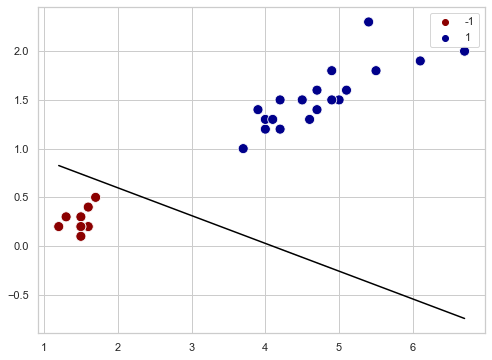

In [368]:
#new_train = train[train[""]]
def wb2mq(w, b):
    assert len(w) == 2, "This implementation only works in 2D"
    assert w[0] != 0 and w[1] != 0 and b != 0 # avoid edge cases for now
    return [w[0]/-w[1], b/-w[1]] # m and q

def params2boundary(w, b):
    #print(b)
    m, q = wb2mq(w, b)
    print(f"m: {m}, q: {q}")
    return lambda x: m*x + q

new_train = train[["petal_length", "petal_width", "species"]]

new_test = test[["petal_length", "petal_width", "species"]]
#new_train
new_margin, new_params = train_svm(new_train, 1.0, 100)
new_params
test_svm(new_params, new_test)
print(new_params)
line = params2boundary(new_params[:-1], new_params[-1])
new_x = new_test[new_test.columns[:-1]].values.tolist()
new_x1 = [val[0] for val in new_x]
new_x2 = [val[1] for val in new_x]
labels = new_test[new_test.columns[-1]].values.tolist()
new_y = [val for val in labels]
#print(new_x1)
#print([line(inp) for inp in new_x1])
sns.scatterplot(x=new_x1, y=new_x2,
      hue=new_y, # let's use different colors for the two classes
      palette=sns.color_palette(['darkred', 'darkblue']),
      s=100)
sns.lineplot(x=new_x1, y=[line(inp) for inp in new_x1], color='black')

#### 2.7 **[2pt]** Classify the 2D dataset using the [scikit-learn implementation](https://scikit-learn.org/stable/modules/svm.html). Mandatory: (i) use the `LinearSVC` implementation (as we did not study kernels yet); (ii) use the same Loss function as in your hand-made implementation (should be easy enough to find), (iii) use a custom value of `C` that tends to ignore margin violations more than $1.0$, but without misclassifying data.

- SVC stands for "Support Vector (Machine) Classifier", while SVR uses the same trick for Regression (**do not** use it here).
- Class `LinearSVC` underneath uses the `liblinear` library, which is highly optimized for linear SVMs. Class `SVC` on the other hand uses `libsvm`, which is more optimized for nonlinear SVMs using kernels. In some cases you may actually get better results on the default parameters with `SVC(kernel='linear')` than you do with `LinearSVC()`, but the latter has a more flexible parametrization (for linear boundaries only), so eventually you should have more room for improvement (you can use a validation set to search for better hyperparaters).
- Remember that this question requires you to access the right datasets for training and test phases, and that you need to split the `x` and `y` as seen last week with NB (that's Naïve Bayes and yes next time you see NB that is what you should expect to mean). 
- You may be tempted to try passing a straight `0` to `C`. Many implementations give errors for `C=0`, but you can get around it by passing a good enough approximation :) remember you can use the scientific notation `1e-x` for decimals, but you really don't need it too small: with a low enough `C` you will start getting misclassified points! Give it a try: do you understand why this happens? (spoiler/hint: think about the English meaning of "maximizing the _margin_ without restrictions", how big a margin can you make if you wish to?)

In [369]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
new_x = new_train[new_train.columns[:-1]].values.tolist()
new_x1 = [val[0] for val in new_x]
new_x2 = [val[1] for val in new_x]
labels = new_train[new_train.columns[-1]].values.tolist()
new_y = [val for val in labels]
test_x = new_test[new_test.columns[:-1]].values.tolist()
test_labels = new_test[new_test.columns[-1]].values.tolist()
test_y = [val for val in test_labels]
clf.fit(new_x, new_y)
predicted = clf.predict(test_x)
#print(predicted)
w, b = clf.coef_[0], clf.intercept_[0]


#### 2.8 **[1pt]** Plot the decision boundary of the SVM over the dataset.

Think carefully and don't mess this up: _which dataset does the question refer to?_ Remember, from now on, we always split our initial data into (at least) two datasets, and all questions referring to learning the parameters use one of the two datasets, while all questions referring to showing the learned model performance should use the other.

[0.58196649 0.85167298] -2.0537974791065396
m: -0.6833215365494969, q: 2.4114860075688944


<AxesSubplot:>

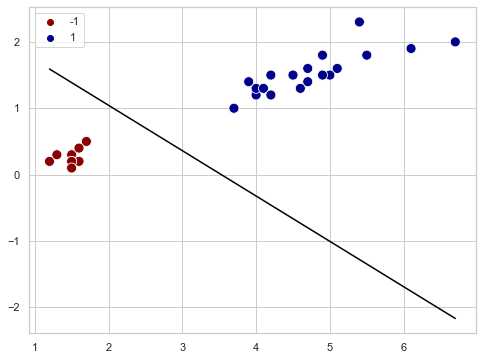

In [370]:
print(w,b)
sci_line = params2boundary(w, b)
test_new_x1 = [val[0] for val in test_x]
test_new_x2 = [val[1] for val in test_x]
test_labels = new_test[new_test.columns[-1]].values.tolist()
test_new_y = [val for val in test_labels]
sns.scatterplot(x=test_new_x1, y=test_new_x2,
      hue=test_new_y, # let's use different colors for the two classes
      palette=sns.color_palette(['darkred', 'darkblue']),
      s=100)
sns.lineplot(x=test_new_x1, y=[sci_line(inp) for inp in test_new_x1], color='black')

# At the end of the exercise

Bonus question with no points! Answering this will have no influence on your scoring, not at the assignment and not towards the exam score -- really feel free to ignore it with no consequence. But solving it will reward you with skills that will make the next lectures easier, give you real applications, and will be good practice towards the exam.

The solution for this questions will not be included in the regular lab solutions pdf, but you are welcome to open a discussion on the Moodle: we will support your addressing it, and you may meet other students that choose to solve this, and find a teammate for the next assignment that is willing to do things for fun and not only for score :)

#### BONUS **[ZERO pt]** Train an SVM on the full Iris dataset (3 classes) using `libsvm`, and print the number of misclassified points. Play with `C` and see how this changes.

#### BONUS **[ZERO pt]** Train you hand-written SVM implementation using the [PEGASOS algorithm](https://github.com/ejlb/pegasos). Now you have a state-of-the-art implementation, congrats! It will actually run better than the scikit-learn `LinearSVM` and `SVC` implementations. Remember this when you need a quick ML result in the future, especially over large data, and performance matters!

To install pegasos (or any other GitHub repository) just switch to a local environment (as shown in the last lecture), then run (from your assignments folder):
```bash
pipenv install -e 'git+https://github.com/ejlb/pegasos.git#egg=pegasos'
```
Here is probably the most complete [guide to Pipenv](https://realpython.com/pipenv-guide). I do not expect a full read (I didn't myself); but if you need something from Pipenv, a quick search in that page will likely point you in the right direction.

If you want to run on `colab`, this could be the right time for you to learn about using "bang commands" in Jupyter notebooks ("bang" being an exclamation mark `!`): they will be run in the shell that is running the Jupyter server. For example you can use `!pip install`. But as mentioned, this is just a hack as you have limited and blind control over your environment, and particularly it will give you problems as soon as you start collaborating with other people on other platforms (the solution is of course a local installation with Pipenv).

### Final considerations

- SVMs are optimal -- when applicable. In particular, if your data is bounded on all features, and you have enough samples from the whole range (so that new points in the test set are expected to be within the same range), then its performance are awesome. And if the data's underlying function is not overly complicated, you don't need an overly complicated model. In the real world and with real data, you are almost guaranteed to get to using a SVM for an application or another at some point in time.
- Remember that easy problems can be often solved with parameter guessing; this also means that if you can solve a problem with parameter guessing, it is an easy problem :) much depends on the model though, with the right model guessing the parameters is efficient, with the wrong model both guessing and training performance drops.
- The main limitation left at this point is handling non-linearities in the data. This is exactly the topic for the next lecture. Be ready as it is more math intensive than linear SVM, but you should have all the pieces now to grasp it completely in the next week.